# Projet Data Analyse – MonMaster 2024  
Problématique : Qu’est-ce qui explique l’attractivité d’une formation de master, et peut-on prédire le nombre de candidatures en 2025 ?

## 1. Importation & Chargement des Données

Chargement du fichier CSV, importation des bibliothèques de base, et vérification de la structure générale du dataset.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration des styles graphiques
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 2. Observation Générale du Dataset

On examine les premières lignes, les types de données, les dimensions et les statistiques de base.

In [12]:
df = pd.read_csv("monmaster.csv", sep=";", encoding="utf-8", low_memory=False)

print("Nombre de lignes et de colonnes :", df.shape)

Nombre de lignes et de colonnes : (8090, 144)


## 3. Sélection des Variables Pertinentes

Création d’un sous-ensemble de colonnes utiles pour l’analyse : discipline, mention, académie, capacité, nombre de candidats et d’admis.

In [13]:
df.head(10)  # Tu peux mettre un autre nombre pour voir plus ou moins de lignes
df.info()
df.describe().T  # .T pour transposer et mieux lire les lignes
missing_values = df.isnull().mean().sort_values(ascending=False) * 100
missing_values[missing_values > 0]  # Affiche uniquement les colonnes concernées
df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8090 entries, 0 to 8089
Columns: 144 entries, Session to Libellé de l'établissement aujourd'hui
dtypes: float64(15), int64(106), object(23)
memory usage: 8.9+ MB


['Session',
 'Phase principale',
 'Phase complémentaire',
 "Identifiant de l'établissement",
 "Libellé de l'établissement",
 "Code de l'académie de l'établissement",
 "Académie de l'établissement",
 "Code de la région académique de l'établissement",
 "Région académique de l'établissement",
 'Identifiant de la formation',
 'Identifiant navette de mention',
 'Intitulé de la mention',
 'Identifiant navette de parcours',
 'Intitulé du parcours',
 'Alternance',
 "Modalités d'enseignement",
 'Lieu(x) de formation',
 "Code de l'académie du lieu de formation",
 'Académie du lieu de formation',
 'Code de la région académique du lieu de formation',
 'Région académique du lieu de formation',
 'Discipline de la formation',
 'Identifiant de la discipline',
 'Discipline',
 'Identifiant du secteur disciplinaire',
 'Secteur disciplinaire',
 'Capacité offerte limitée par la formation',
 'Effectif de candidats ayant confirmé une candidature en phase principale',
 'Effectif de candidats ayant confirmé un

## 4. Nettoyage des Données

Nettoyage complet du dataset pour s'assurer de la fiabilité de l'analyse :
- Gestion des valeurs manquantes
- Correction des types
- Suppression ou remplacement de données incohérentes
- Création de nouvelles variables utiles

In [15]:
# 1. Définir les colonnes utiles
cols_utiles = [
    "Intitulé de la mention",
    "Discipline",
    "Académie du lieu de formation",
    "Modalités d'enseignement",
    "Alternance",
    "Capacité offerte limitée par la formation",
    "Effectif de candidats ayant confirmé une candidature en phase principale",  # N_can_pp
    "Effectif de candidats ayant accepté une proposition d'admission pour une candidature formulée en phase principale ou en phase complémentaire",  # N_accept_total
]

# 2. Créer le DataFrame nettoyé
df_clean = df[cols_utiles].copy()

# 3. Renommer les colonnes pour simplifier
df_clean.rename(columns={
    "Intitulé de la mention": "mention",
    "Discipline": "discipline",
    "Académie du lieu de formation": "academie",
    "Modalités d'enseignement": "modalite",
    "Alternance": "alternance",
    "Capacité offerte limitée par la formation": "capacite",
    "Effectif de candidats ayant confirmé une candidature en phase principale": "N_can_pp",
    "Effectif de candidats ayant accepté une proposition d'admission pour une candidature formulée en phase principale ou en phase complémentaire": "N_accept_total"
}, inplace=True)


In [16]:
# ✅ Afficher le pourcentage de valeurs manquantes par colonne
missing_percent = df_clean.isnull().mean().sort_values(ascending=False) * 100
missing_percent[missing_percent > 0]

modalite    1.285538
dtype: float64

In [ ]:
# Remplacer les valeurs manquantes de la modalité par "Inconnue"
df_clean["modalite"] = df_clean["modalite"].fillna("Inconnue")

In [20]:
# Liste des colonnes à convertir en catégorie
colonnes_categ = ["mention", "discipline", "modalite", "alternance", "academie"]

# Conversion
for col in colonnes_categ:
    df_clean[col] = df_clean[col].astype("category")

df_clean.dtypes

mention           category
discipline        category
academie          category
modalite          category
alternance        category
capacite             int64
N_can_pp             int64
N_accept_total       int64
dtype: object

In [22]:
# Vérification de doublons exacts
print("Nombre de doublons :", df_clean.duplicated().sum())

# Suppression si nécessaire
df_clean = df_clean.drop_duplicates()

# Suppression des lignes dupliquées
df_clean = df_clean.drop_duplicates()

# Vérification
print("Nouvelle taille du dataset :", df_clean.shape)

Nombre de doublons : 0
Nouvelle taille du dataset : (8008, 8)


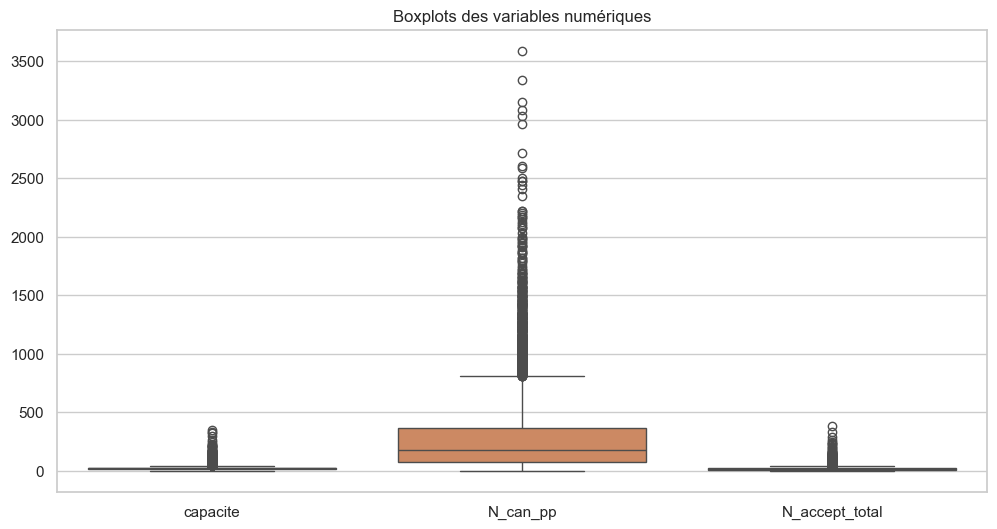

In [23]:
sns.boxplot(data=df_clean[["capacite", "N_can_pp", "N_accept_total"]])
plt.title("Boxplots des variables numériques")
plt.show()

### 🎯 Analyse des outliers et justification

Lors de l’analyse des boxplots des variables numériques `capacite`, `N_can_pp` (nombre de candidats) et `N_accept_total` (nombre d’admis), plusieurs valeurs extrêmes ont été observées, notamment :

- Des capacités dépassant 500 places
- Des formations avec plus de 1000 voire 3000 candidats
- Des formations acceptant jusqu’à 600 personnes

#### 🔍 Décision : **les outliers ont été conservés**

**Pourquoi ?**
- Ces valeurs reflètent une **réalité structurelle** du système MonMaster : certaines formations (en droit, psycho, éco-gestion...) accueillent naturellement des centaines voire des milliers de candidats.
- Ces formations sont **au cœur de la problématique** d'attractivité : les supprimer reviendrait à **cacher les cas les plus significatifs**.
- Ils sont **essentiels pour la phase de modélisation** : prédire le nombre de candidatures ou la tension suppose de garder ces extrêmes.

💡 *Ils seront éventuellement traités à l'étape de visualisation (ex : ajustement d’échelle) ou de modélisation (transformation log), mais jamais supprimés.*

## 5. Analyse Bivariée

Analyse de la relation entre deux variables à la fois, pour détecter les facteurs qui influencent l’attractivité d’une formation.

**Objectif** : Identifier les variables corrélées avec `N_can_pp` (nombre de candidats), afin de mieux comprendre ce qui attire les étudiants.

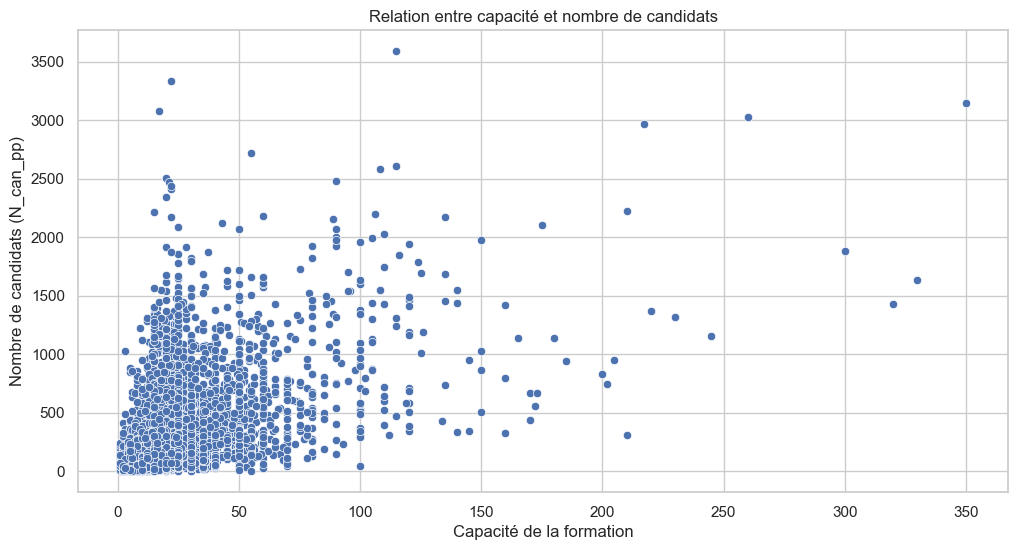

Corrélation capacite ↔ N_can_pp : 0.50


In [24]:
# Scatterplot entre capacité et nombre de candidats
sns.scatterplot(x="capacite", y="N_can_pp", data=df_clean)
plt.title("Relation entre capacité et nombre de candidats")
plt.xlabel("Capacité de la formation")
plt.ylabel("Nombre de candidats (N_can_pp)")
plt.show()

# Calcul du coefficient de corrélation de Pearson
corr = df_clean["capacite"].corr(df_clean["N_can_pp"])
print(f"Corrélation capacite ↔ N_can_pp : {corr:.2f}")

➡️ La capacité d’accueil influence partiellement le nombre de candidatures.  
Mais la corrélation de 0.50 montre que des formations très demandées peuvent rester très sélectives avec peu de places.  
Nous devons explorer d'autres facteurs influents comme la discipline ou la localisation.

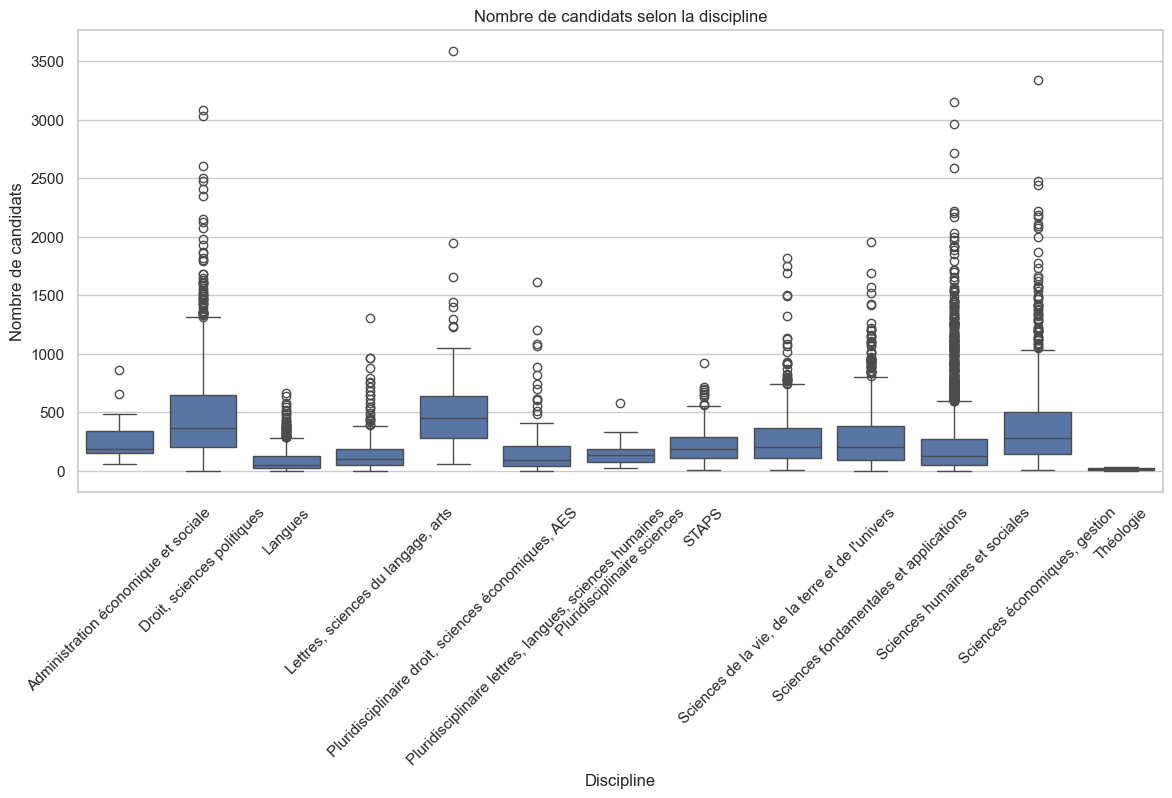

In [25]:
# Boxplot du nombre de candidats selon la discipline
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_clean, x="discipline", y="N_can_pp")
plt.title("Nombre de candidats selon la discipline")
plt.ylabel("Nombre de candidats")
plt.xlabel("Discipline")
plt.xticks(rotation=45)
plt.show()

### Discipline et attractivité

La discipline d'une formation joue un rôle majeur dans son attractivité.  
Certaines disciplines concentrent un nombre de candidatures très élevé, notamment :

- **Droit, économie, gestion**
- **Sciences humaines et sociales**
- **AES (Administration Économique et Sociale)**

Cela peut s'expliquer par :
- Le **nombre d’étudiants en licence dans ces domaines**
- La **visibilité des débouchés**
- Une **offre plus centralisée** (moins de masters accessibles = plus de candidats par formation)

➡️ Ce facteur sera **essentiel dans le modèle de prédiction du nombre de candidats en 2025.**

### Analyse de la modalité d’enseignement – Approche 1 : répartition globale (boxplot)

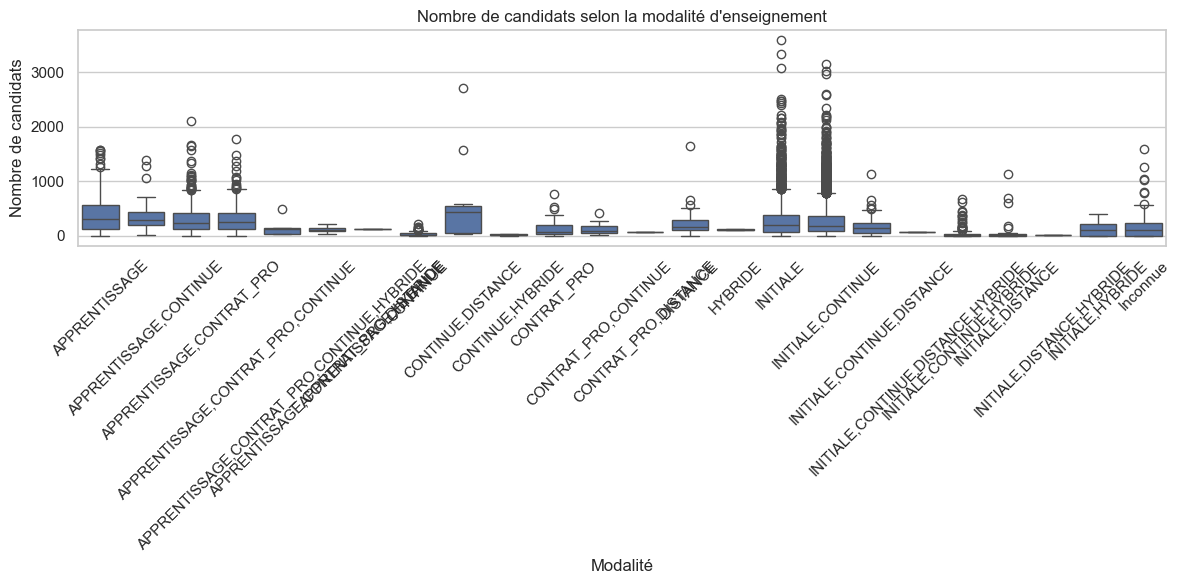

In [27]:
# Boxplot du nombre de candidats selon la modalité d’enseignement
sns.boxplot(data=df_clean, x="modalite", y="N_can_pp")
plt.title("Nombre de candidats selon la modalité d'enseignement")
plt.xlabel("Modalité")
plt.ylabel("Nombre de candidats")
plt.xticks(rotation=45)  # pour incliner les intitulés
plt.tight_layout()       # pour bien ajuster l’affichage
plt.show()

### Analyse de la modalité d’enseignement – Approche 2 : moyenne de candidats par modalité

/var/folders/y8/ghc5lkjj70vf0ggbg680pgsw0000gn/T/ipykernel_37734/1078204103.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_clean.groupby("modalite")["N_can_pp"].mean().sort_values(ascending=False).plot(kind="bar")


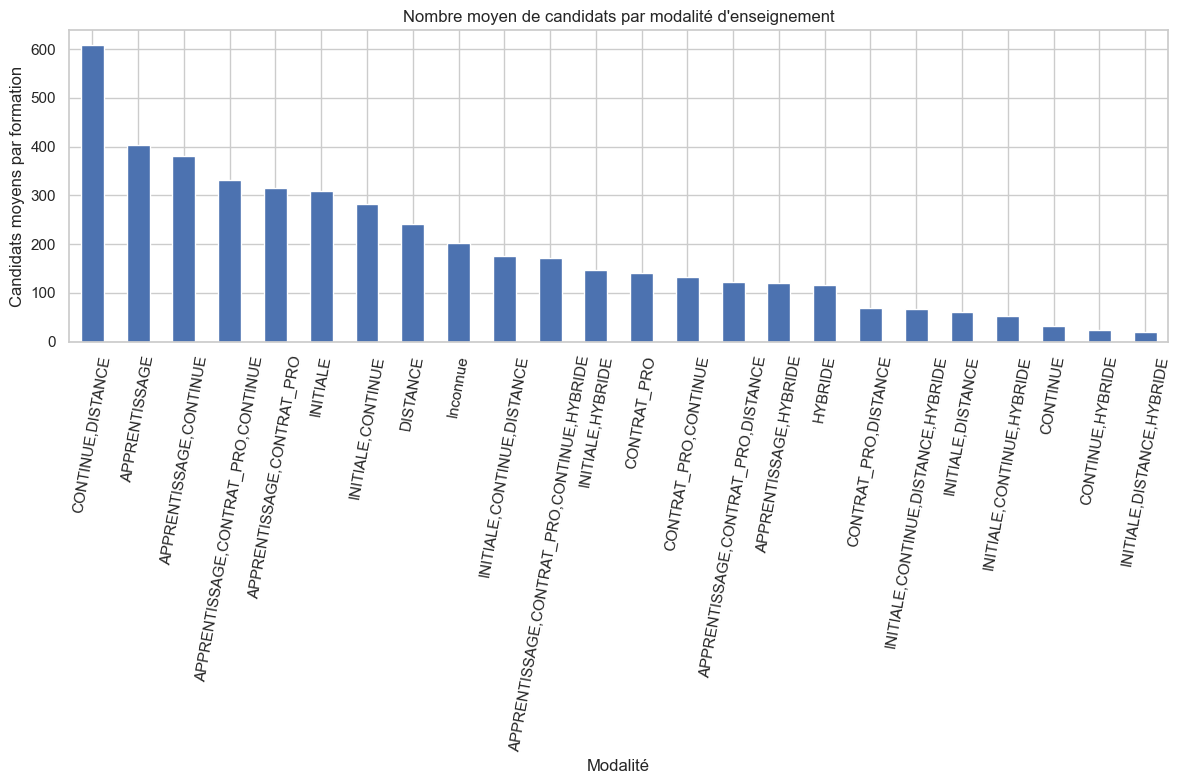

In [32]:
plt.figure(figsize=(12, 8))
df_clean.groupby("modalite")["N_can_pp"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Nombre moyen de candidats par modalité d'enseignement")
plt.ylabel("Candidats moyens par formation")
plt.xlabel("Modalité")
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### Comparaison fine des modalités – Nombre moyen de candidats par formation

En analysant les **moyennes de candidatures par formation**, on obtient une lecture plus juste de l'attractivité réelle par modalité.

➡️ Les résultats montrent que certaines modalités **moins nombreuses** attirent **plus de candidats par formation** :
- **CONTINUE.DISTANCE** arrive en tête
- Les formats **APPRENTISSAGE**, **APPRENTISSAGE.CONTINUE**, etc., sont très performants
- Le **présentiel INITIALE** est très répandu, mais son attractivité moyenne par formation est plus modérée

🔎 Cela souligne l'importance de **croiser les analyses visuelles** (boxplots) et **statistiques** (moyennes) pour éviter les biais.

✅ Ce critère sera intégré dans notre modélisation prédictive pour 2025.

/var/folders/y8/ghc5lkjj70vf0ggbg680pgsw0000gn/T/ipykernel_37734/937060487.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  moy_candidats_par_academie = df_clean.groupby("academie")["N_can_pp"].mean().sort_values(ascending=False)


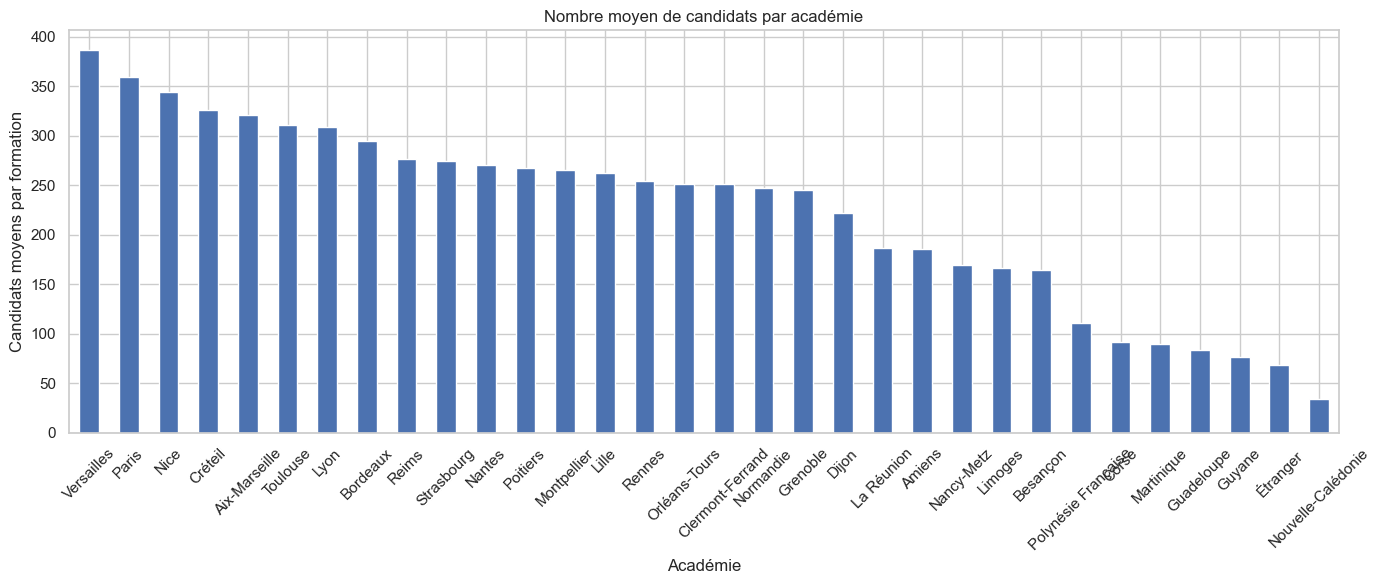

In [33]:
# Calcul du nombre moyen de candidats par académie
moy_candidats_par_academie = df_clean.groupby("academie")["N_can_pp"].mean().sort_values(ascending=False)

# Visualisation
plt.figure(figsize=(14, 6))
moy_candidats_par_academie.plot(kind="bar")
plt.title("Nombre moyen de candidats par académie")
plt.ylabel("Candidats moyens par formation")
plt.xlabel("Académie")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analyse géographique – Attractivité par académie

Certaines académies concentrent une **très forte demande par formation**, notamment :
- **Versailles, Paris, Créteil**
- Suivies de **Nice, Aix-Marseille, Toulouse, Lyon**

Cela peut s’expliquer par :
- Une **offre plus concentrée** (moins de formations pour beaucoup d’étudiants)
- La **réputation académique** ou la localisation stratégique
- La **centralisation de certaines disciplines (ex : droit, éco-gestion, sciences sociales)**

Inversement, des zones comme la **Guyane, la Guadeloupe, ou la Polynésie** présentent une tension très faible.

🎯 Cette variable géographique est **essentielle dans la modélisation** du nombre de candidats, notamment pour prédire les tensions futures.